# Imports

In [126]:
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import pickle


# Constants

In [127]:
TRAIN = '../data/interim/train.csv'
DEV   = '../data/interim/dev.csv'
TEST  = '../data/interim/test.csv'

# Functions

In [128]:
def loader(PATH):
    with open(PATH, mode ='r')as file:
        csvFile = csv.reader(file)
        text = []
        for lines in csvFile:
            text.append(lines)
    return text


def splitter(L):
    X = []
    y = []
    for i in L:
        X.append(i[0])
        y.append(int(i[1]))
        
    return X, y

# Load Data

In [129]:
train_data = loader(TRAIN) # Training
dev_data = loader(DEV)     # Validation
X_test = loader(TEST)      # Test

In [130]:
len(train_data), len(dev_data), len(X_test)

(100000, 10000, 10000)

In [131]:
# Uncomment to select a subset of the data
train_data = train_data[0:5] 
dev_data = dev_data[0:10]
X_test = X_test[0:10]

In [132]:
train_data[0]

['Gotta listen to this! So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!',
 '1']

# Tokenize

In [133]:
def tknzr(sentence):
    """Function to find all tokens in a given sentence
    """
    tok = re.compile('[\'\"]|[A-Za-z]+|[.?!:\'\"]+')
    
    return tok.findall(sentence)

In [134]:
X_train, y_train = splitter(train_data)
X_dev, y_dev = splitter(dev_data)

In [135]:
# hand-made tokenization
print(tknzr(X_train[0]))

['Gotta', 'listen', 'to', 'this', '!', 'So', 'creative', '!', 'Love', 'his', 'music', 'the', 'words', 'the', 'message', '!', 'Some', 'of', 'my', 'favorite', 'songs', 'on', 'this', 'CD', '.', 'I', 'should', 'have', 'bought', 'it', 'years', 'ago', '!']


In [136]:
X_train_tokens = []
for sentence in X_train:
    temp = tknzr(sentence)
    if len(temp) > 0:
        if len(temp) > 500:
            X_train_tokens.append(temp[0:500])
        else: X_train_tokens.append(temp)
    else: X_train_tokens.append('NULL')
print(len(X_train_tokens))

5


In [137]:
for x in X_train_tokens:
    if len(x) == 0 or len(x) > 500:
        print(x)

In [138]:
for i in X_train_tokens:
    if i == []:
        print('!!!')

In [139]:
X_dev_tokens = []
for sentence in X_dev:
    X_dev_tokens.append(tknzr(sentence))
print(len(X_dev_tokens))

10


In [140]:
X_test[0], X_train[0]

(['ok ok'],
 'Gotta listen to this! So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!')

In [141]:
X_test_tokens = []
for sentence in X_test:
    X_test_tokens.append(tknzr(str(sentence)))
print(len(X_test_tokens))

10


# Check for GPU

In [142]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [143]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [144]:
# Encode our concatenated data
encoded_ = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train_tokens]

In [145]:
l = 0
for sent in encoded_:
    if len(sent) > l:
        l = len(sent)
        
print(l)

44


In [146]:
# Specify `MAX_LEN`
MAX_LEN = l

# Print sentence 0 and its encoded token ids
token_ids = preprocessing_for_bert(X_train[0:2])
print('Original: ', X_train[0])
print('Token IDs: ', token_ids[0])


# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_dev)
print('F\'ing Done!!')

Original:  Gotta listen to this! So creative!  Love his music - the words, the message! Some of my favorite songs on this CD. I should have bought it years ago!
Token IDs:  tensor([[  101, 10657,  4952,  2000,  2023,   999,  2061,  5541,   999,  2293,
          2010,  2189,  1011,  1996,  2616,  1010,  1996,  4471,   999,  2070,
          1997,  2026,  5440,  2774,  2006,  2023,  3729,  1012,  1045,  2323,
          2031,  4149,  2009,  2086,  3283,   999,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  9467,  9467,  2023,  6823,  2064,  6684,  2022,  5319,  1998,
          2009,  2001,  3205,  2005,  5096,  2004,  1000,  2200,  2204,  1000,
          1012,  2009,  1005,  1055,  2200,  2919,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])
Tokenizing data...
F'ing Done!!


In [147]:
len(train_inputs), len(train_masks), len(val_inputs), len(val_masks)

(5, 5, 10, 10)

In [148]:
train_inputs

tensor([[  101, 10657,  4952,  2000,  2023,   999,  2061,  5541,   999,  2293,
          2010,  2189,  1011,  1996,  2616,  1010,  1996,  4471,   999,  2070,
          1997,  2026,  5440,  2774,  2006,  2023,  3729,  1012,  1045,  2323,
          2031,  4149,  2009,  2086,  3283,   999,   102,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  9467,  9467,  2023,  6823,  2064,  6684,  2022,  5319,  1998,
          2009,  2001,  3205,  2005,  5096,  2004,  1000,  2200,  2204,  1000,
          1012,  2009,  1005,  1055,  2200,  2919,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  4965,  1996,  3729,  1012,  2079,  2025,  4965,  1996, 23378,
          1012,  4965,  1996,  3729,  1012,  2079,  2025,  4965,  1996, 23378,
          2201,  1012,  8816,  2003,  2053,  2936,  2800,  1012,  2021,  2017,
          2123,  1005,  1056,  2424,  2008,  2041,  212

In [149]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_dev)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Train Model

In [150]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size, max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size, num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 81.8 µs


# Optimizer

In [151]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [152]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

# Start Training

In [153]:
%%time
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/dmdequin/miniconda3/envs/uni/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated 

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    0    |   0.671327   |     -      |     -     |   2.08   
----------------------------------------------------------------------
   1    |    -    |   0.671327   |  0.703941  |   40.00   |   2.49   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    0    |   0.571595   |     -      |     -     |   1.65   
----------------------------------------------------------------------
   2    |    -    |   0.571595   |  0.696200  |   50.00   |   2.06   
----------------------------------------------------------------------


Training complete!
CPU times: user 19.6 s, sys: 5.45 s, total: 25.1 s
Wall time: 9.22 s


# Save model

In [168]:
# save model
model = bert_classifier
pickle.dump(model, open('model.pkl', 'wb'))

In [172]:
# load the model
model = pickle.load(open('model.pkl', 'rb'))

# Run Preprocessing on test data

In [173]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing and embed data...')
test_inputs, test_masks = preprocessing_for_bert(X_test_tokens)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing and embed data...


In [174]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [175]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Predict Test data

In [176]:
%%time
# Compute predicted probabilities on the validation set
probs = bert_predict(model, val_dataloader)

CPU times: user 2.55 s, sys: 344 ms, total: 2.89 s
Wall time: 604 ms


In [177]:
# Get predictions from the probabilities
threshold = 0.63
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of reviews predicted positive: ", preds.sum())

print(f'Accuracy: {round(100 * sum(preds==y_dev)/len(y_dev), 2)}%')

Number of reviews predicted positive:  0
Accuracy: 60.0%


AUC: 0.6667
Accuracy: 50.00%


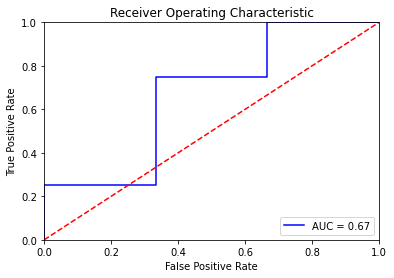

In [178]:
# Evaluate the Bert classifier
evaluate_roc(probs, y_dev)

In [179]:
%%time
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

CPU times: user 2.8 s, sys: 266 ms, total: 3.06 s
Wall time: 652 ms


In [180]:
# Get predictions from the probabilities
threshold = 0.63
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of reviews predicted positive: ", preds.sum())

Number of reviews predicted positive:  0


In [181]:
preds

y_hat = []

for i in preds:
    if i:
        y_hat.append('positive')
    else: y_hat.append('negative')

y_hat[0:10]

['negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative']

In [165]:
a= 5000
b= a + 20
[i for i in zip(y_hat[a:b], X_test[a:b])]

[]

In [167]:
import pandas as pd

test_pred = pd.read_json( '../data/raw/music_reviews_test_masked.json.gz', lines=True)

test_pred['sentiment'] = y_hat

test_pred.head(10)

ValueError: Length of values (10) does not match length of index (10000)

In [ ]:
test_pred.to_json('../data/predictions/music_reviews_test.json', orient='records')